## Tarea Semanal Nro 7 | Filtrado digital lineal de ECG

#### **Introducción y fundamentos teóricos**
##### *Propuesta*

Usando el archivo ecg.mat que contiene un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:


- Ruido causado por el movimiento de los electrodos (Alta frecuencia).
- Ruido muscular (Alta frecuencia).
- Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia).


In [21]:
from pytc2.sistemas_lineales import plot_plantilla
import sympy as sp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import firls

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)



In [22]:


#Cargar la señal ECG
fs = 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')

# Extraer las señales
ecg = mat_struct['ecg_lead'].flatten()
hb1 = mat_struct['heartbeat_pattern1'].flatten()
hb2 = mat_struct['heartbeat_pattern2'].flatten()
qrs = mat_struct['qrs_pattern1'].flatten()
qrs_det = mat_struct['qrs_detections'].flatten()

# Normalización tipo z-score: (x - media) / std
def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

# Aplicar normalización
ecg = normalize(ecg)
hb1 = normalize(hb1)
hb2 = normalize(hb2)
qrs = normalize(qrs)

# Crear un vector de tiempo para la señal ECG completa
t_ecg = np.arange(len(ecg)) / fs

# Crear vectores de tiempo para los patrones (usualmente de menor duración)
t_hb1 = np.arange(len(hb1)) / fs
t_hb2 = np.arange(len(hb2)) / fs
t_qrs = np.arange(len(qrs)) / fs




#### Armo una plantilla de diseño con los siguientes requerimientos

f_stop1 = 0.1 Hz (Contaminación de la línea de base)

f_pass1 = 1 Hz (Mínima frecuencia de la onda T)

f_pass2 = 35 Hz (Ancho de banda calculado en la Ts 5)

f_stop2 = 50 Hz (Ruido de la red eléctrica en Argentina)


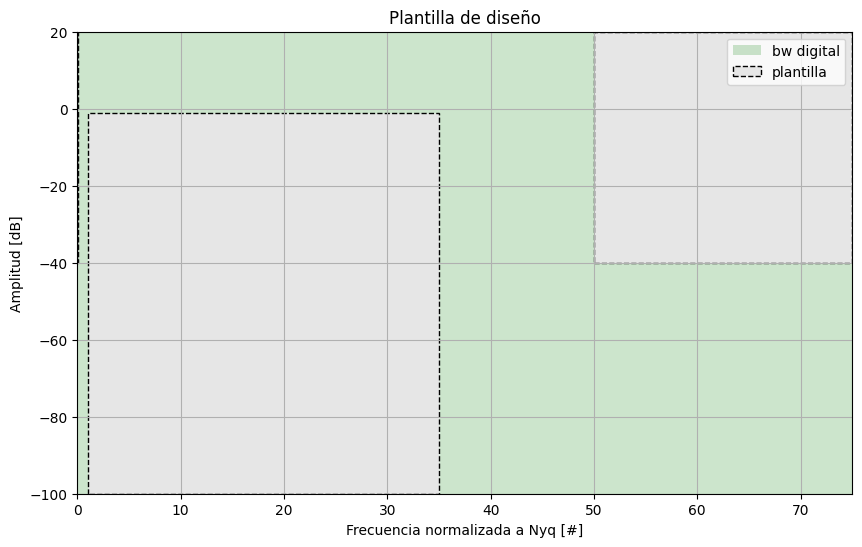

In [23]:

#########################################
########## PLANTILLA DE DISEÑO ##########
#########################################

# Configuración de la plantilla de diseño del filtro
fpass = np.array([1,35])
ripple = 1
fstop = np.array([0.1,50.0])
attenuation = 40

plt.figure(figsize=(10, 6))
plt.title('Plantilla de diseño')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.xlim(0, 75)
plt.ylim(-100,20)
plt.grid(which='both', axis='both')
plot_plantilla(filter_type='bandpass', fpass=fpass, ripple=ripple, fstop=fstop, attenuation=attenuation, fs=fs)



# Grilla logarítmica y lineal en Hz
w_log = np.logspace(np.log10(0.1), np.log10(20), 600)   # logarítmica de 0.1 a 20 Hz
w_lin = np.linspace(20, fs/2, 600, endpoint=True)       # lineal de 20 Hz a fs/2
w_rad = np.unique(np.concatenate((w_log, w_lin)))       # une y elimina duplicados
w_rad = np.unique(w_rad)  # elimina duplicados 



#### Armo los filtros tipo IIR y verifico que cumplen con la plantilla sin problemas

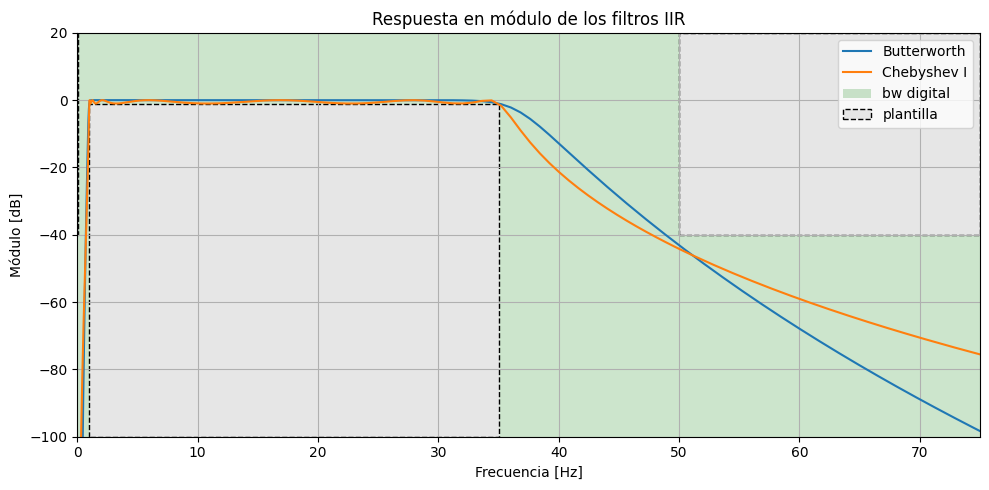

In [24]:

###########################################
############### FILTROS IIR ###############
###########################################

############# BUTTER ###############
sos_filter_vent = sig.iirdesign(fpass, fstop, ripple, attenuation, ftype='butter', output='sos',fs=fs)
w_b, hh_b = sig.sosfreqz(sos_filter_vent, worN=w_rad, fs=fs)

############# CHEBVY 1 ###############
sos_filter_ch = sig.iirdesign(fpass, fstop, ripple, attenuation, ftype='cheby1', output='sos',fs=fs)
w_c, hh_c = sig.sosfreqz(sos_filter_ch, worN=w_rad, fs=fs)

# Graficar la respuesta en módulo (dB)
plt.figure(figsize=(10, 5))
plt.plot(w_b, 20 * np.log10(np.abs(hh_b) + 1e-15), label='Butterworth')
plt.plot(w_c, 20 * np.log10(np.abs(hh_c) + 1e-15), label='Chebyshev I')
plt.title('Respuesta en módulo de los filtros IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid(which='both', axis='both')
plt.xlim(0, 75)
plt.ylim(-100,20)
plt.legend()
plt.tight_layout()
plot_plantilla(filter_type='bandpass', fpass=fpass, ripple=ripple, fstop=fstop, attenuation=attenuation, fs=fs)



#### Armo los filtros FIR en cascada, con ordenes enormes y observo que aún así tienen problemas para cumplir con las especificaciones de la plantilla

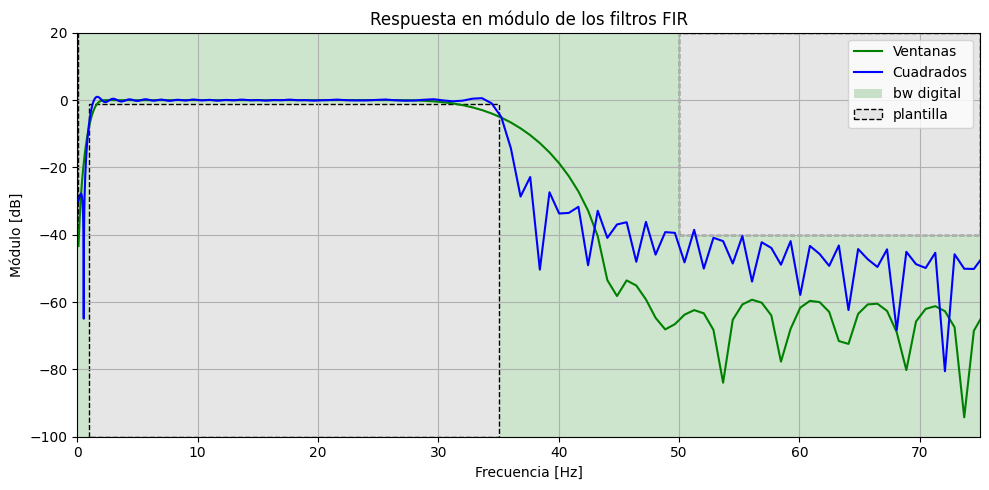

In [25]:

###########################################
############### FILTROS FIR ###############
###########################################


######### METODO VENTANAS #########
# --- Filtro pasaaltos FIR ---
freq_hp = [0, fpass[0]*0.98, fpass[0], fs/2]
gain_hp = [0, 0, 1, 1]
freq_hp = np.array(freq_hp)

numtaps = 1501  # Orden 
b_hp = sig.firwin2(numtaps, freq_hp, gain_hp, fs=fs)

# --- Filtro pasabajos FIR ---
freq_lp = [0, fpass[1], fpass[1]*1.02, fs/2]
gain_lp = [1, 1, 0, 0]
freq_lp = np.array(freq_lp)

numtaps = 201  # Orden 
b_lp = sig.firwin2(numtaps, freq_lp, gain_lp, fs=fs)

# --- Convolucionamos ambos filtros para obtener el pasabanda ---
b_vent = np.convolve(b_hp, b_lp)

# --- Respuesta en frecuencia del filtro FIR pasabanda ---
w_fir, h_fir = sig.freqz(b_vent, worN=w_rad, fs=fs)

####### METODO CUADRADOS MINIMOS #########

# --- Filtro pasaaltos FIR (firls) ---
numtaps = 1501  # Orden 
bands_hp = [0, fpass[0]*0.98, fpass[0], fs/2]
desired_hp = [0, 0, 1, 1]
bands_hp = np.array(bands_hp)
bands_hp_norm = bands_hp / (fs/2)
b_firls_hp = firls(numtaps, bands_hp_norm, desired_hp)

# --- Filtro pasabajos FIR (firls) ---
numtaps = 501  # Orden 
bands_lp = [0, fpass[1], fpass[1]*1.02, fs/2]
desired_lp = [1, 1, 0, 0]
bands_lp = np.array(bands_lp)
bands_lp_norm = bands_lp / (fs/2)
b_firls_lp = firls(numtaps, bands_lp_norm, desired_lp)

# --- Convolucionamos ambos filtros para obtener el pasabanda ---
b_firls = np.convolve(b_firls_hp, b_firls_lp)

# --- Respuesta en frecuencia del filtro FIR pasabanda (firls) ---
w_firls, h_firls = sig.freqz(b_firls, worN=w_rad, fs=fs)


# --- Graficar junto a los FIR ---
plt.figure(figsize=(10, 5))
plt.plot(w_fir, 20 * np.log10(np.abs(h_fir) + 1e-15), label='Ventanas', color='green')
plt.plot(w_firls, 20 * np.log10(np.abs(h_firls) + 1e-15), label='Cuadrados', color='blue')
plt.title('Respuesta en módulo de los filtros FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid(which='both', axis='both')
plt.xlim(0, 75)
plt.ylim(-100, 20)
plt.legend()
plt.tight_layout()
plot_plantilla(filter_type='bandpass', fpass=fpass, ripple=ripple, fstop=fstop, attenuation=attenuation, fs=fs)
plt.show()



#### Aplico los filtros con filtfilt para miticar las demoras y distorsión de fase

In [26]:

#########################################
######### APLICANDO LOS FILTROS #########
#########################################


# Aplicar el filtro Butterworth (sin desfase)
ecg_butter = sig.sosfiltfilt(sos_filter_vent, ecg)
# Aplicar el filtro Chebyshev I (sin desfase)
ecg_cheby = sig.sosfiltfilt(sos_filter_ch, ecg)
# Aplicar el filtro FIR por Ventanas (sin desfase)
ecg_vent = sig.filtfilt(b_vent, 1.0, ecg)
# Aplicar el filtro FIR por Cuadrados Mínimos (sin desfase)
ecg_cuad = sig.filtfilt(b_firls, 1.0, ecg)



#### Grafico las regiones de interes y observo el filtrado en cada caso. 

Se filtran ondas lentas y rápidas. Observo el segmento PQ que tiene pequeña varianza, es donde mayor cambio hay.

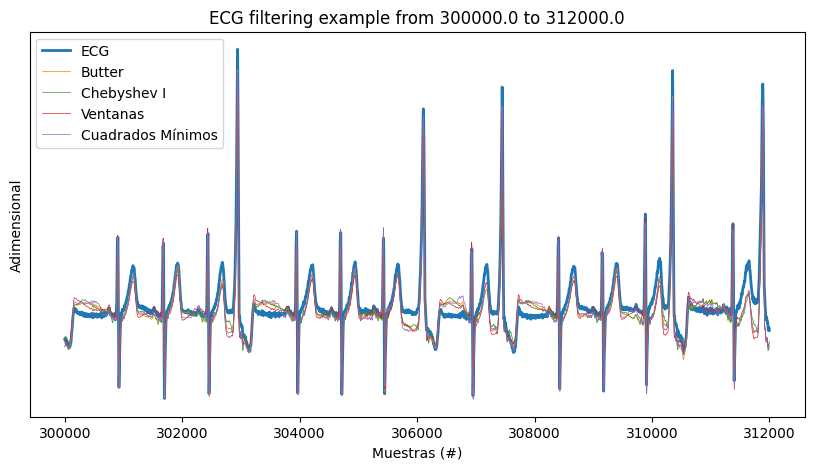

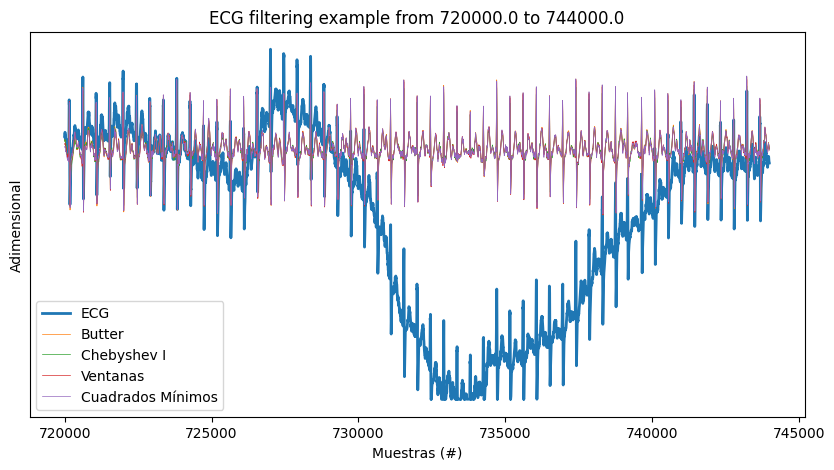

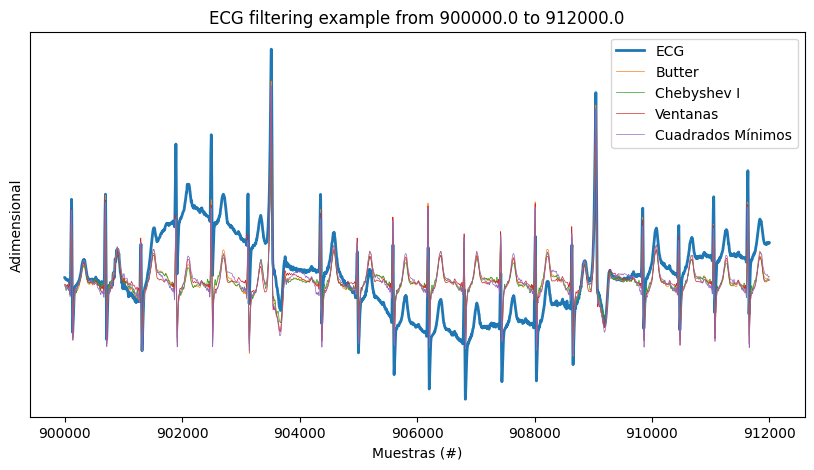

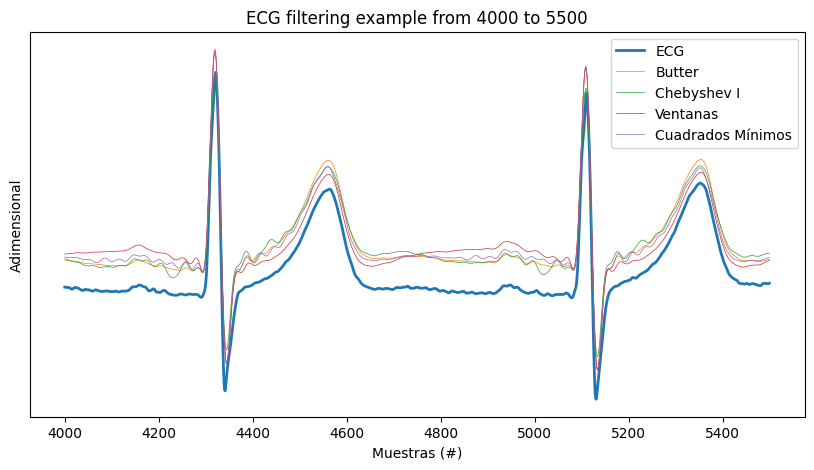

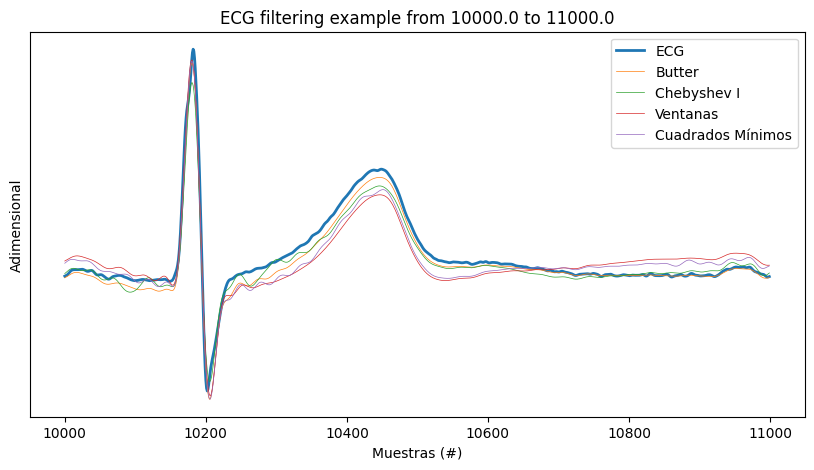

In [27]:

########### GRAFICOS TEMPORALES ###########

cant_muestras = ecg.shape[0]
fig_sz_x = 10
fig_sz_y = 5
fig_dpi = 100
demora = 0

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_butter[zoom_region + demora], label='Butter',linewidth=0.5)
    plt.plot(zoom_region, ecg_cheby[zoom_region + demora], label='Chebyshev I',linewidth=0.5)
    plt.plot(zoom_region, ecg_vent[zoom_region + demora], label='Ventanas',linewidth=0.5)
    plt.plot(zoom_region, ecg_cuad[zoom_region + demora], label='Cuadrados Mínimos',linewidth=0.5)

    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

    ###### ESPECTROGRAMAS ######

    # Calcular el periodograma de Welch para cada señal
nperseg = 2048


#### Gráfico espectral, chequeo que mitigue las frecuencias correspondientes

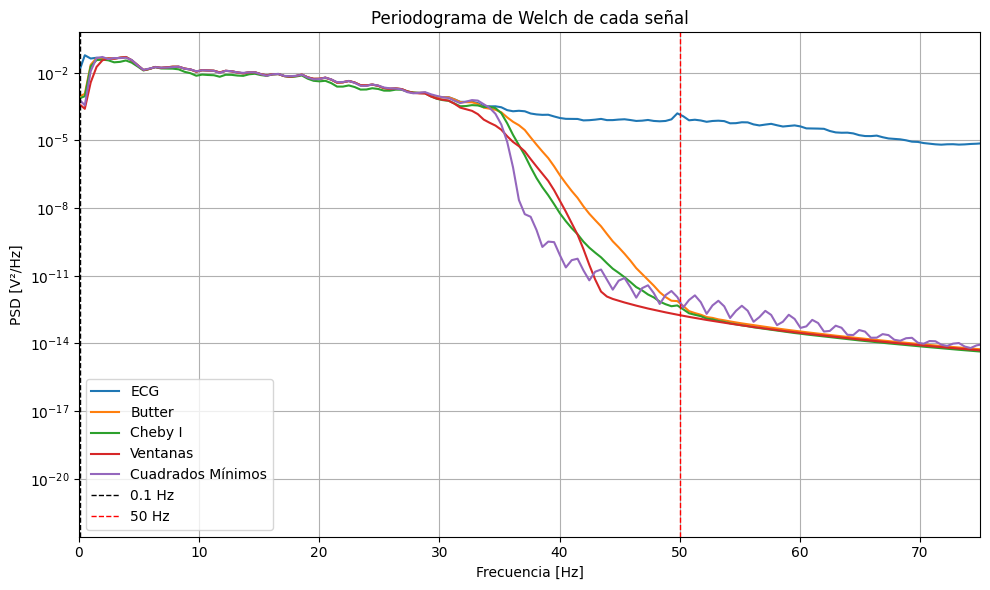

In [28]:

############# GRÁFICOS ESPECTRALES #############
f_ecg, Pxx_ecg = sig.welch(ecg, fs=fs, nperseg=nperseg)
f_butter, Pxx_butter = sig.welch(ecg_butter, fs=fs, nperseg=nperseg)
f_cheby, Pxx_cheby = sig.welch(ecg_cheby, fs=fs, nperseg=nperseg)
f_vent, Pxx_vent = sig.welch(ecg_vent, fs=fs, nperseg=nperseg)
f_cuad, Pxx_cuad = sig.welch(ecg_cuad, fs=fs, nperseg=nperseg)

plt.figure(figsize=(10, 6))
plt.semilogy(f_ecg, Pxx_ecg, label='ECG')
plt.semilogy(f_butter, Pxx_butter, label='Butter')
plt.semilogy(f_cheby, Pxx_cheby, label='Cheby I')
plt.semilogy(f_vent, Pxx_vent, label='Ventanas')
plt.semilogy(f_cuad, Pxx_cuad, label='Cuadrados Mínimos')

plt.axvline(0.1, color='k', linestyle='--', linewidth=1, label='0.1 Hz')
plt.axvline(50, color='r', linestyle='--', linewidth=1, label='50 Hz')

plt.title('Periodograma de Welch de cada señal')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [V²/Hz]')
plt.xlim(0, 75)
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()